In [2]:
import pandas as pd
from datetime import datetime
import json,os
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False
colors = sns.color_palette() 

In [4]:
df=pd.read_excel('data/patent_invest_2024_先进制造_医疗健康_3.xlsx',index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172418 entries, 0 to 172417
Data columns (total 62 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   公司序号             172418 non-null  int64         
 1   公司简称             172418 non-null  object        
 2   工商全称             171909 non-null  object        
 3   成立时间             172418 non-null  datetime64[ns]
 4   公司简介             172418 non-null  object        
 5   省                172418 non-null  object        
 6   市                172397 non-null  object        
 7   行业               172418 non-null  object        
 8   子行业              172418 non-null  object        
 9   经度               172418 non-null  float64       
 10  纬度               172418 non-null  float64       
 11  估算估值             158944 non-null  float64       
 12  首次上市日期           38304 non-null   datetime64[ns]
 13  目前已上市            172418 non-null  int64         
 14  高科技企业            172418 n

In [5]:
import requests
import hashlib
import random
import json

appid = '2024052500207777'
secret_key = '7777'
def translate_text(text, from_lang='zh', to_lang='en'):
    url = 'https://fanyi-api.baidu.com/api/trans/vip/translate'
    salt = random.randint(32768, 65536)
    sign = appid + text + str(salt) + secret_key
    sign = hashlib.md5(sign.encode()).hexdigest()
    params = {
        'q': text,
        'from': from_lang,
        'to': to_lang,
        'appid': appid,
        'salt': salt,
        'sign': sign
    }
    response = requests.get(url, params=params)
    result = response.json()
    if 'trans_result' in result:
        return result['trans_result'][0]['dst']
    else:
        return text 

In [6]:
translate_text('子行业')

'Sub industry'

In [7]:
trans_Sub_industry={i:translate_text(i) for i in  df['子行业'].unique()}
trans_Sub_industry

{'通信制造': 'Communication manufacturing',
 '集成电路': 'integrated circuit',
 '机器人': 'robot',
 '家用电器': 'Household appliances',
 'AR/VR设备': 'AR/VR devices',
 '可穿戴设备': 'wearable devices ',
 '传感设备': 'Sensing equipment',
 '智能装备': 'Intelligent equipment',
 '电子设备': 'Electronic devices',
 '无人机': 'unmanned aerial vehicle',
 '新能源': 'new energy',
 '新材料': 'New materials',
 '工业4.0': 'Industry 4.0',
 '3D打印': '3D printing',
 '国防军工': 'National Defense and Military Industry',
 '其他工业': 'Other industries',
 '航空航天': 'Aerospace',
 '医生服务': 'Doctor services',
 '寻医诊疗': 'Seeking medical treatment',
 '行业信息化及解决方案': 'Industry informatization and solutions',
 '健康保健': 'Health care',
 '医疗器械': 'Medical devices',
 '医疗综合服务': 'Comprehensive medical services',
 '医疗信息化': 'Medical informatization',
 '专科医疗': 'Specialized medical care',
 '医疗机构': 'medical institution',
 '中医中药': 'Traditional Chinese Medicine',
 '医药流通': 'Medical circulation',
 '生物技术和制药': 'Biotechnology and pharmaceuticals',
 '其他医疗服务': 'Other medical services',
 '数据服

In [8]:
df['Sub industry']=df['子行业'].map(trans_Sub_industry)

(-1.0999999884300435,
 1.0999997570309128,
 -1.0999999816834682,
 1.09999961542844)

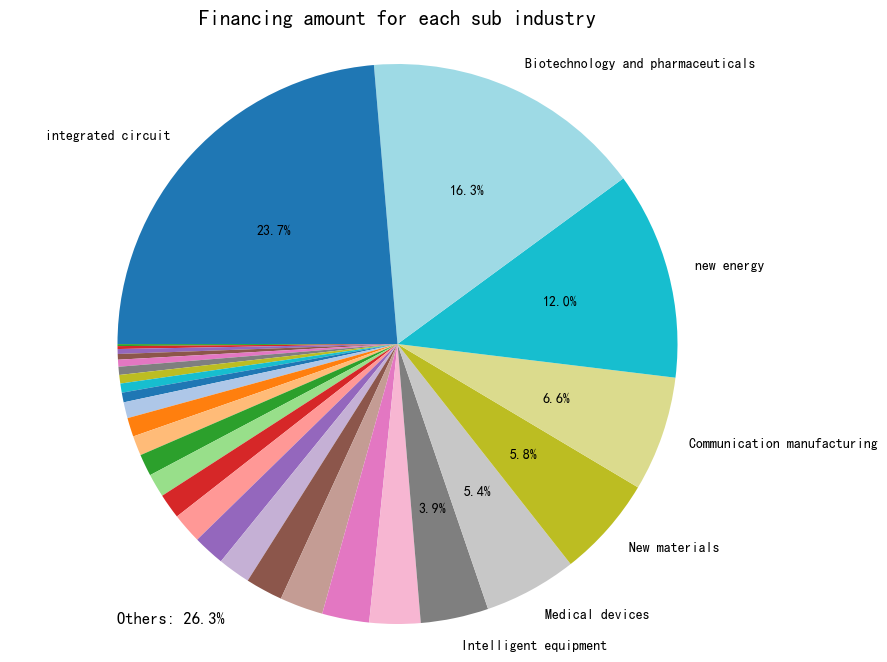

In [72]:
## figure4-1
d1=df.groupby('Sub industry')['等值人民币（万）'].sum().sort_values()

total=d1.values.sum()
labels_filtered = [label if size / total >= 0.03 else '' for label, size in zip(d1.index, d1.values)]
def format_auto_label(pct):
    return '{:.1f}%'.format(pct) if pct >= 3 else '' 

plt.figure(figsize=(10,8))
plt.pie(d1.values, labels=labels_filtered, autopct=format_auto_label,colors=(plt.cm.tab10.colors+plt.cm.tab20.colors), startangle=180)#autopct='%1.1f%%
# 如果有占比小于5%的标签，添加额外的标签显示其总和

small_sizes_sum = sum([size for size in d1.values if size / total < 0.03])
if small_sizes_sum > 0:
    plt.text(-1, -1, f"Others: {small_sizes_sum / total * 100:.1f}%", fontsize=12)

plt.title(translate_text('各子行业融资金额'), va='bottom', fontsize=15)
plt.axis('equal')

<Axes: title={'center': 'Average financing frequency for each sub industry'}, ylabel='Sub industry'>

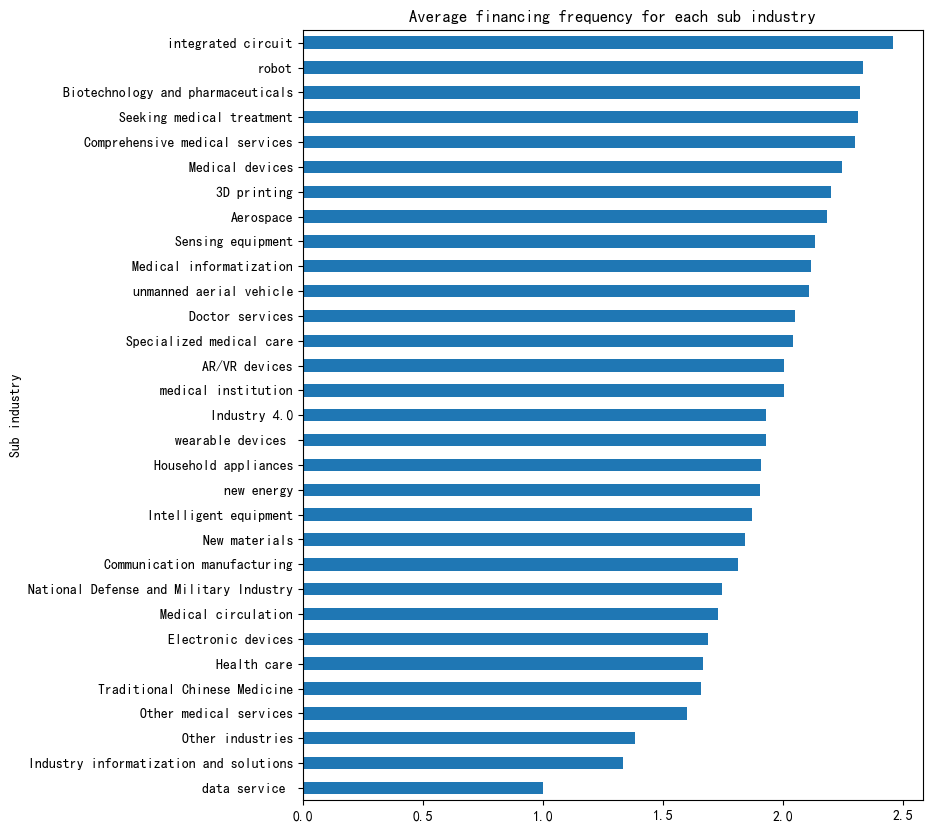

In [11]:
## figure4-2-1 Average Number of Financings
d4=df.groupby(['Sub industry','公司序号'],as_index= False).融资时间.count()
d4.groupby('Sub industry').融资时间.mean().rename('平均融资次数').sort_values().plot.barh(title=translate_text('每个子行业的平均融资次数'),figsize=(8,10))#ascending=False

In [15]:
df['融资阶段_初创/商业化'] = df['轮次'].dropna().apply(lambda x: '初创融资阶段' if any(tag in x for tag in ['种子轮','天使轮','Pre-A','A轮','A+轮','Pre-B轮','B轮','B+轮','C轮','D轮'])
else '商业化融资阶段' )

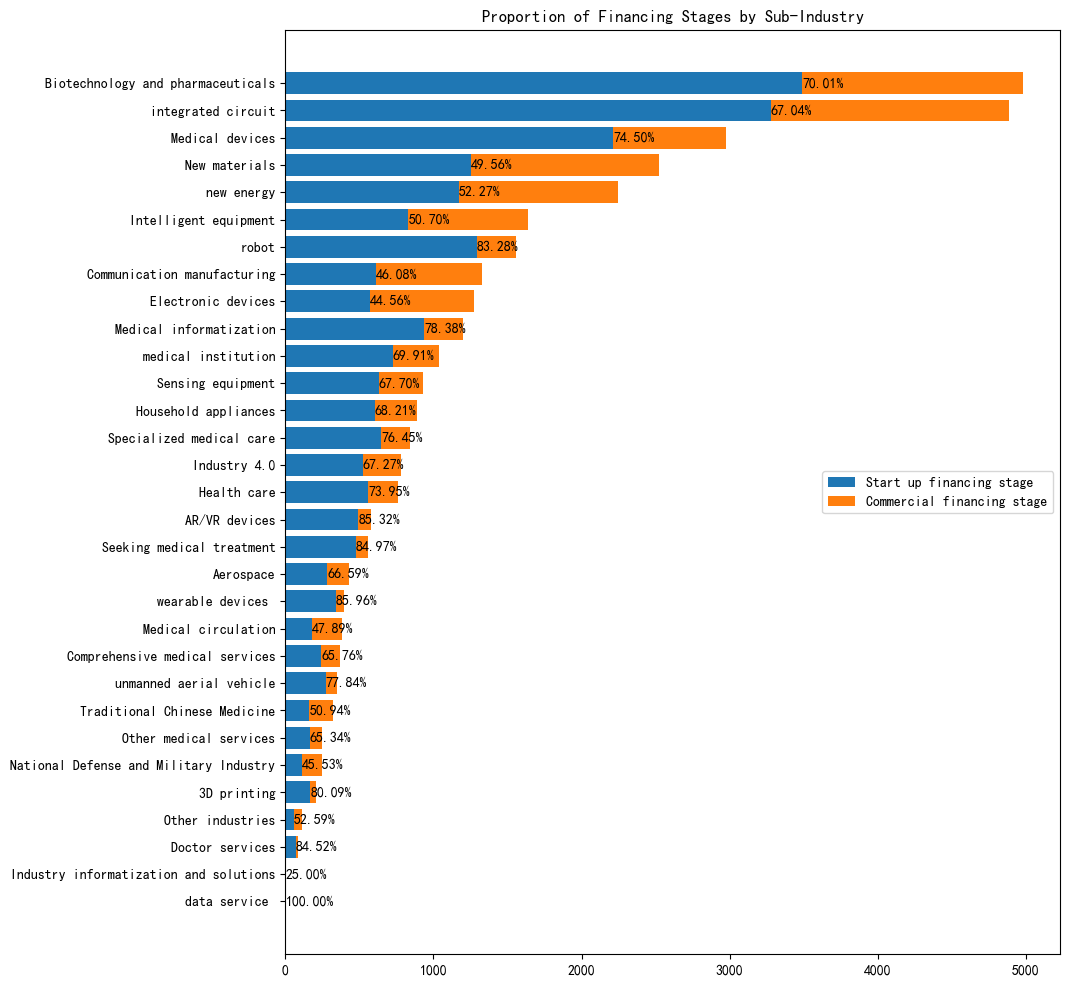

In [16]:
## figure4-2-2 Proportion of Financing Stages by Sub-Industry

tmp=df.pivot_table(columns='融资阶段_初创/商业化',index='Sub industry',values='公司序号',aggfunc='count',margins=True).sort_values(by='All')[:-1] #nunique
yb=np.zeros(tmp.shape[0])
plt.figure(figsize=(10,12))
plt.barh(tmp.index,width=tmp['初创融资阶段'],label=translate_text('初创融资阶段'))
yb+=tmp['初创融资阶段']
tmp_1=tmp['初创融资阶段']/tmp['All']
for i, value in enumerate(tmp['初创融资阶段']):
    plt.text(value, i, f'{tmp_1.iloc[i]:.2%}', va='center')
plt.barh(tmp.index,width=tmp['商业化融资阶段'],left=yb,label=translate_text('商业化融资阶段'))#height,bottom
yb+=tmp['商业化融资阶段']
plt.title('Proportion of Financing Stages by Sub-Industry')
plt.legend()

In [17]:
translate_text('省')

'province'

In [19]:
trans_province={i:translate_text(i) for i in  df['省'].unique()}
trans_province

{'北京': 'Beijing',
 '广东': 'Guangdong',
 '上海': 'Shanghai',
 '江苏': 'Jiangsu Province',
 '山东': 'Shandong Province',
 '浙江': 'Zhejiang',
 '贵州': 'Guizhou',
 '四川': 'Sichuan',
 '陕西': 'Shaanxi',
 '湖北': 'Hubei Province',
 '台湾': 'Taiwan',
 '香港': 'Hong Kong',
 '天津': 'Tianjin',
 '福建': 'Fujian',
 '辽宁': 'Liaoning',
 '黑龙江': 'Heilongjiang',
 '湖南': 'Hunan',
 '河南': 'Henan Province',
 '安徽': 'Anhui',
 '重庆': 'Chongqing',
 '河北': 'Hebei Province',
 '江西': 'Jiangxi',
 '云南': 'Yunnan',
 '新疆': 'Xinjiang',
 '甘肃': 'Gansu',
 '山西': 'Shanxi',
 '吉林': 'Jilin',
 '内蒙古': 'Inner Mongolia',
 '广西': 'Guangxi',
 '西藏': 'Xizang',
 '宁夏': 'Ningxia',
 '海南': 'Hainan',
 '青海': 'Qinghai Province'}

In [75]:
df['province']=df['省'].map(trans_province).str.replace(' Province','')

<Axes: title={'center': 'Total Financing Amount by Province'}, xlabel='province'>

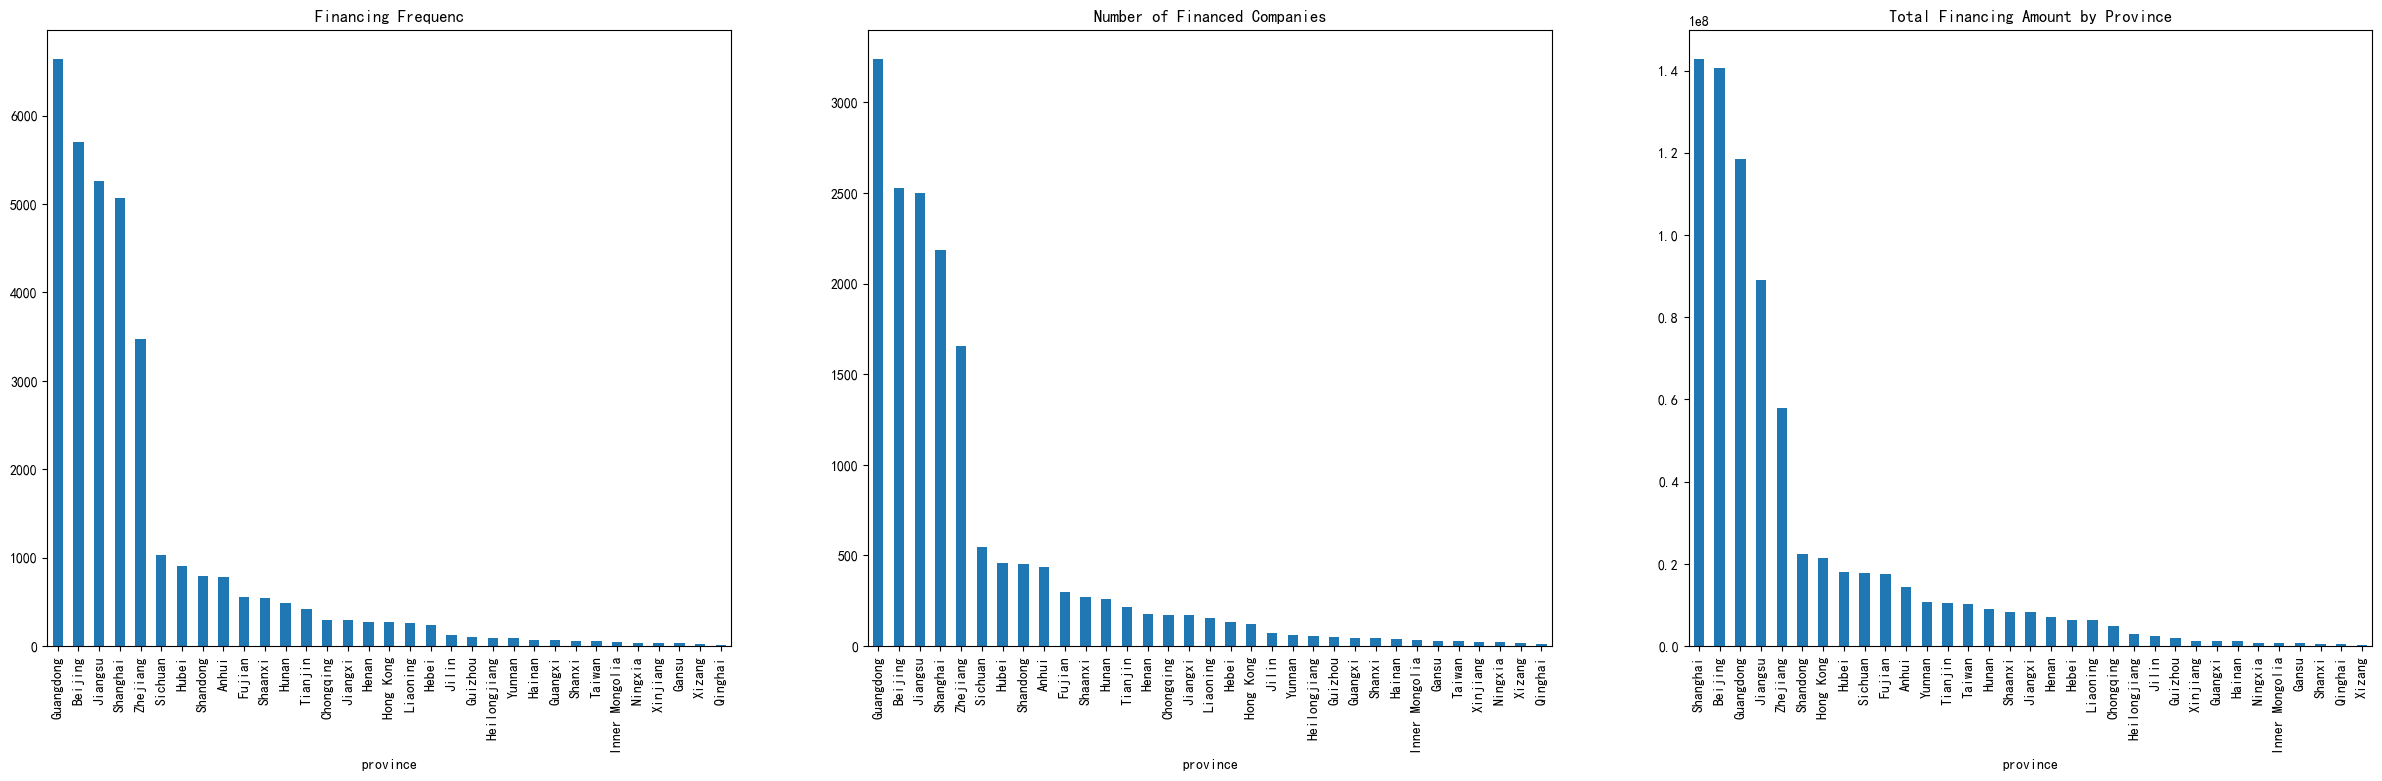

In [76]:
## figure4-3 Financing Frequency, Number of Financed Companies, and Total Financing Amount by Province

fig=plt.figure(figsize=(30,8))
fig.add_subplot(1,3,1)
df.groupby(['province']).融资时间.count().sort_values(ascending=False).plot.bar(title='Financing Frequenc')
fig.add_subplot(1,3,2)
df.groupby(['province']).公司序号.nunique().sort_values(ascending=False).plot.bar(title='Number of Financed Companies')
fig.add_subplot(1,3,3)
df.groupby(['province'])['等值人民币（万）'].sum().sort_values(ascending=False).plot.bar(title='Total Financing Amount by Province')

In [73]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

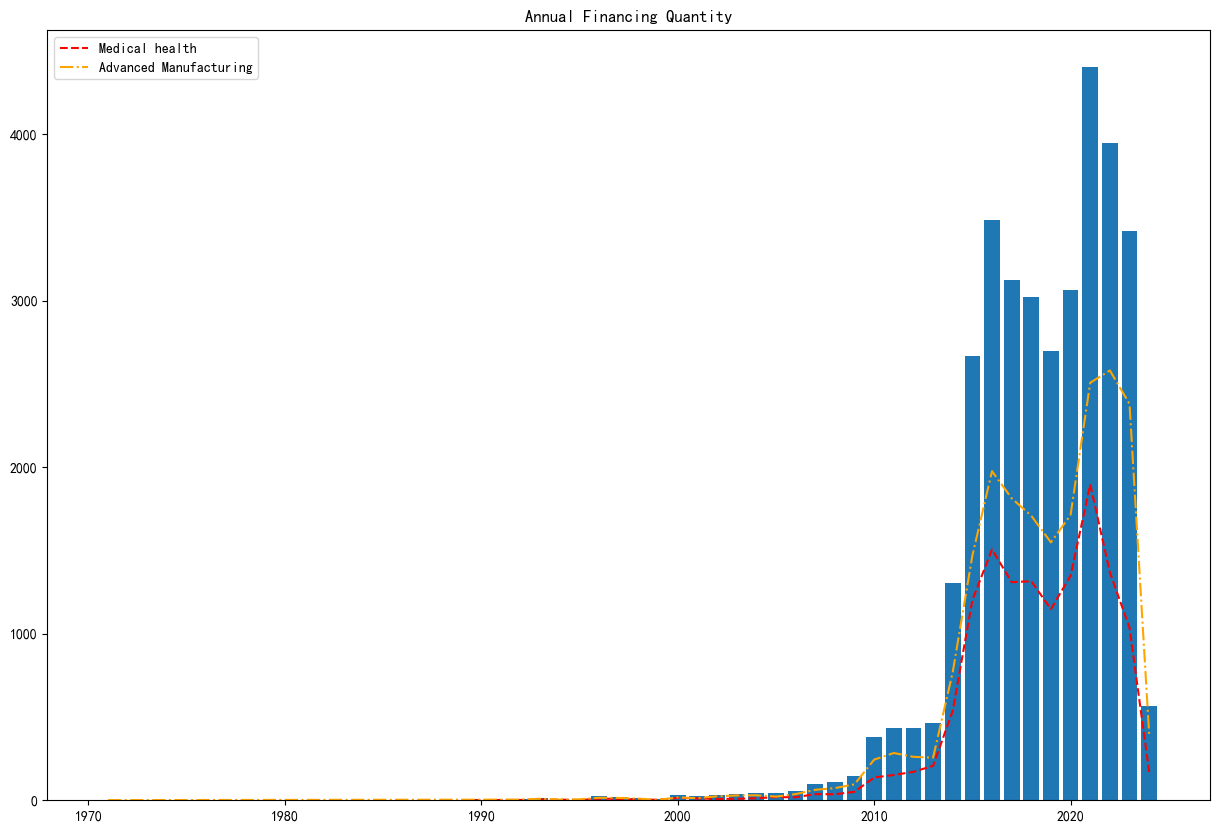

In [24]:
# Figure 4-4 Annual Financing Quantity 

d5=df.groupby(['融资年份']).融资时间.count()
plt.figure(figsize=(15,10))
plt.bar(d5.index,d5.values)
plt.plot(df.query("行业=='医疗健康'").groupby(['融资年份']).融资时间.count(),linestyle='--',color='red',label=translate_text('医疗健康'))
plt.plot(df.query("行业=='先进制造'").groupby(['融资年份']).融资时间.count(),linestyle='-.',color='orange',label=translate_text('先进制造'))
plt.title('Annual Financing Quantity')#各年度融资数量'
plt.legend()
#plt.grid(True)

In [19]:
df.query("行业=='医疗健康'")['Application_num'].sum(),df.query("行业=='先进制造'")['Application_num'].sum()#(融资时间_last<='申请日'<融资时间)['申请号'].nunique()，观察年统计周期没去重,观察年->专利申请年,非融资年,当前期年度没融资是累计的

(661359.0, 4115308.0)

In [20]:
#df.drop_duplicates('投资时间_Shift',keep='last')
mask=df.groupby('公司序号',group_keys=False)['投资时间_Shift'].apply(lambda x:x.duplicated(keep='last'))
df_1=df[~mask]
df_1[['公司简称','观察年','投资时间_Shift','Application_num']]

,公司简称,观察年,投资时间_Shift,Application_num
2,WiPlug推,2013,NaT,NaN
3,WiPlug推,2014,2013-03-01,NaN
5,21克手机,2012,NaT,NaN
7,21克手机,2014,2012-04-04,13.0
9,21克手机,2016,2014-06-05,4.0
...,...,...,...,...
172398,康迪医药,2024,NaT,NaN
172405,光声制药,2024,NaT,8.0
172410,太希智能,2024,NaT,25.0
172412,途深智合,2024,NaT,3.0


In [21]:
#df.groupby(['行业', '子行业']).size().reset_index(name='条数')
df_1.groupby(['行业', '子行业'])['Application_num'].sum().reset_index(name='专利个数')

,行业,子行业,专利个数
0,先进制造,3D打印,6035.0
1,先进制造,AR/VR设备,6586.0
2,先进制造,传感设备,23028.0
3,先进制造,其他工业,3100.0
4,先进制造,可穿戴设备,7997.0
5,先进制造,国防军工,15473.0
6,先进制造,家用电器,286260.0
7,先进制造,工业4.0,30156.0
8,先进制造,新材料,79936.0
9,先进制造,新能源,115815.0


In [22]:
df_1.pivot_table(columns='行业',index='子行业',values='Application_num',aggfunc='sum',margins=True)

行业,先进制造,医疗健康,All
子行业,,,
3D打印,6035.0,NaN,6035.0
AR/VR设备,6586.0,NaN,6586.0
专科医疗,NaN,5634.0,5634.0
中医中药,NaN,6299.0,6299.0
传感设备,23028.0,NaN,23028.0
健康保健,NaN,8671.0,8671.0
其他医疗服务,NaN,4487.0,4487.0
其他工业,3100.0,NaN,3100.0
医生服务,NaN,460.0,460.0


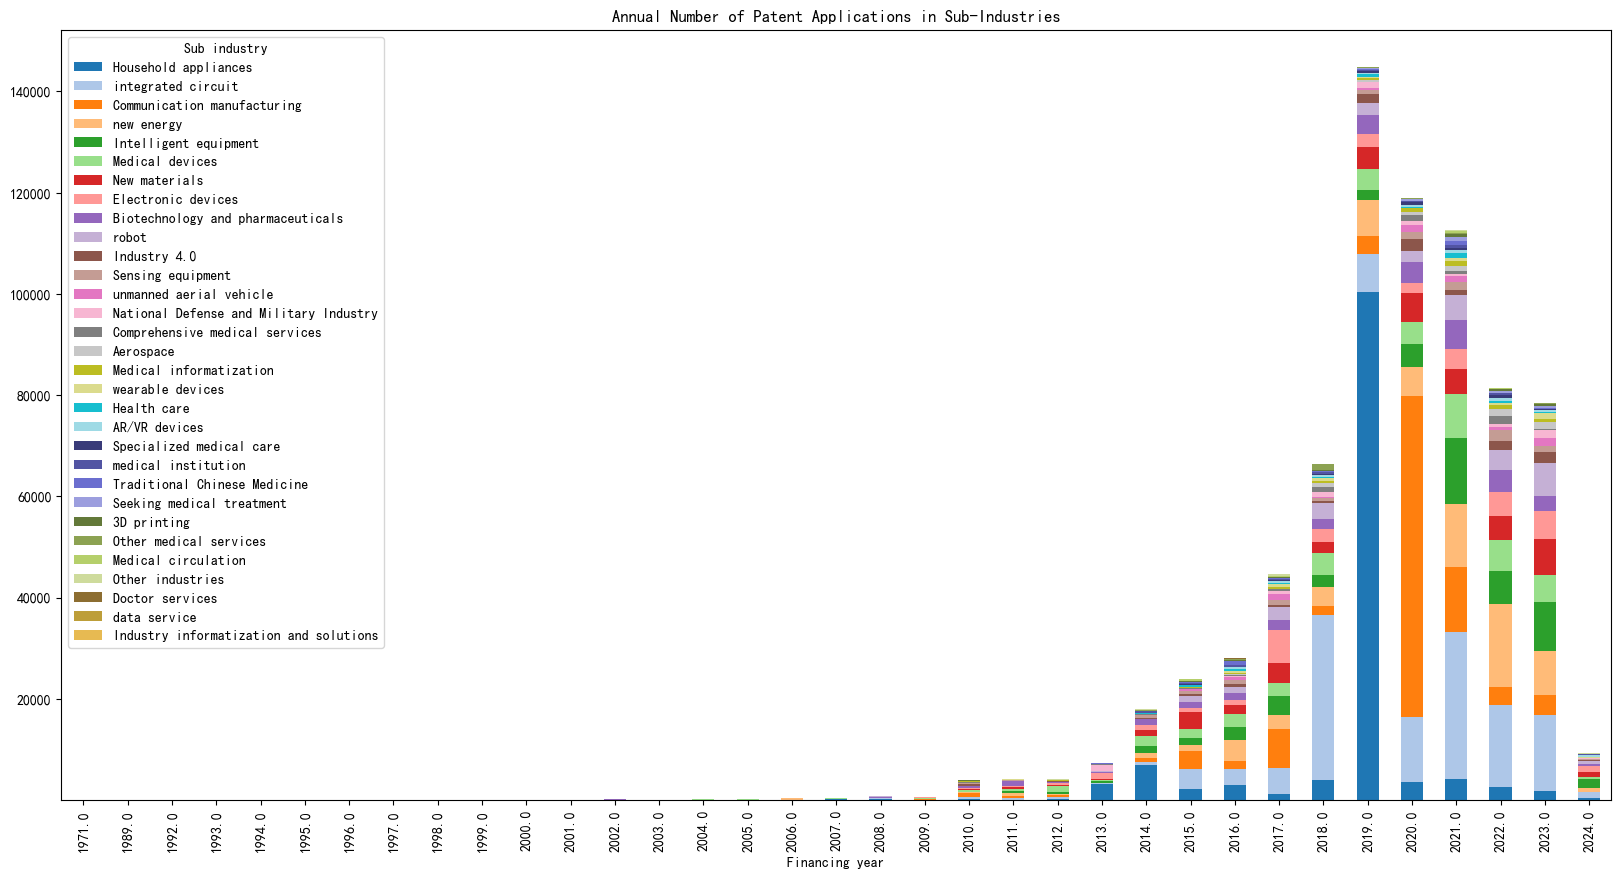

In [45]:
# Figure 4-6 Annual Number of Patent Applications in Sub-Industries
d8=df.pivot_table(columns='Sub industry',index='融资年份',values='Application_num',aggfunc='sum')
d8=d8[d8.sum().sort_values(ascending=False).index]

colors = (plt.cm.tab20.colors+plt.cm.tab20b.colors)[:len(d8.columns)]#plt.cm.tab10.colors
#colors_with_alpha = [(r, g, b, alpha) for (r, g, b), alpha in zip(colors, np.linspace(0.5, 1, len(d8.columns)))]
d8.plot.bar(stacked=True,color=colors,figsize=(20,10))


plt.title('Annual Number of Patent Applications in Sub-Industries')#每年各子行业申请专利数量趋势
plt.xlabel(translate_text('融资年份'))
plt.legend(title='Sub industry')

<Axes: title={'center': 'Total Number of Investment Institutions in Sub-Industry'}, ylabel='Sub industry'>

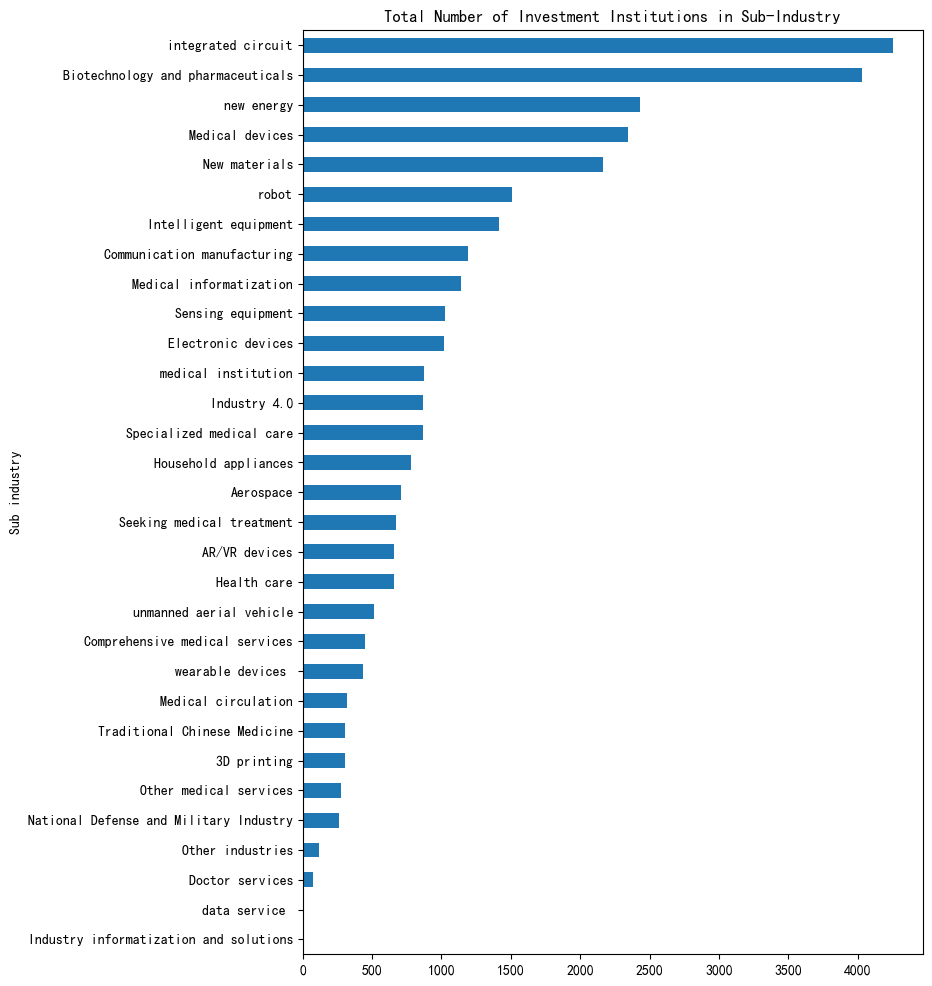

In [27]:
# Figure 4-5 Total Number of Investment Institutions in Sub-Industry
df.groupby('Sub industry').apply(lambda x:x['投资机构'].str.split('|').explode().str.strip().replace('', np.nan).dropna().nunique()).sort_values().plot.barh(title='Total Number of Investment Institutions in Sub-Industry',figsize=(8,12))